In [24]:
import os
import pandas as pd
from tqdm import tqdm

# 设置文件夹路径
folder_path = 'multi_backtest_result/performance'

# 初始化一个列表来存储所有的数据帧及其元信息
data_frames = []

# 遍历指定文件夹内的所有xlsx文件
for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.xlsx'):
        # 构建完整的文件路径
        file_path = os.path.join(folder_path, filename)
        
        # 读取每个文件的指定sheets
        df_cumulative_return = pd.read_excel(file_path, sheet_name='cumulative_return', index_col=0)
        df_daily_return = pd.read_excel(file_path, sheet_name='daily_return', index_col=0)
        df_turnover_rates = pd.read_excel(file_path, sheet_name='turnover_rates', index_col=0)
        
        # 合并三个DataFrame
        df_combined = pd.concat([df_cumulative_return, df_daily_return, df_turnover_rates], axis=1)
        
        # 解析文件名以获取算法类型，窗口大小和资产数量
        parts = filename.split('_')
        algo_type = parts[1]  # 算法类别
        window_size = int(parts[3])  # 窗口大小
        asset_count = int(parts[5].split('.')[0])  # 资产数量
        
        # 创建一个包含数据和元数据的字典
        data_info = {
            'dataframe': df_combined,
            'algorithm_type': algo_type,
            'window_size': window_size,
            'asset_count': asset_count
        }
        
        # 将字典添加到列表中
        data_frames.append(data_info)

100%|██████████| 108/108 [01:05<00:00,  1.64it/s]


In [25]:
data_frames[0]['dataframe']

,cumulative_return,daily_return,turnover_rates
2000-06-14,0.000000,0.000000,NaN
2000-06-15,-0.004352,-0.004352,NaN
2000-06-16,-0.014048,-0.009738,0.232338
2000-06-19,-0.000447,0.013794,0.349507
2000-06-20,-0.012377,-0.011935,0.385157
...,...,...,...
2023-12-25,6.513370,-0.000060,0.595533
2023-12-26,6.549187,0.004767,0.476523
2023-12-27,6.549382,0.000026,0.338856
2023-12-28,6.561308,0.001580,0.374196


In [27]:
# 创建新的DataFrame的列
columns = ['window_size', 'k_value', 'final_return', 'std', 'daily_turnover']
portfolio_performance = pd.DataFrame(columns=columns)

# 遍历之前创建的包含所有文件数据的data_frames列表
for item in data_frames:
    df_combined = item['dataframe']
    window_size = item['window_size']
    asset_count = item['asset_count']

    # 提取cumulative_return的最后一个值
    final_return = df_combined['cumulative_return'].iloc[-1]
    
    # 计算daily_return的标准差
    std_return = df_combined['daily_return'].std()
    
    # 计算turnover_rates最后250天的均值
    if 'turnover_rates' in df_combined.columns and len(df_combined['turnover_rates']) > 250:
        daily_turnover = df_combined['turnover_rates'].tail(250).mean()
    else:
        daily_turnover = df_combined['turnover_rates'].mean()
    
    # 将这些数据添加到新的DataFrame中
    portfolio_performance = portfolio_performance.append({
        'window_size': window_size,
        'k_value': asset_count,
        'final_return': final_return,
        'std': std_return,
        'daily_turnover': daily_turnover
    }, ignore_index=True)


In [28]:
portfolio_performance

,window_size,k_value,final_return,std,daily_turnover
0,100.0,10.0,6.531098,0.013504,0.417146
1,100.0,100.0,6.305711,0.009946,0.365620
2,100.0,20.0,8.930929,0.011832,0.421972
3,100.0,200.0,6.375460,0.010003,0.341373
4,100.0,30.0,6.892247,0.010767,0.403102
...,...,...,...,...,...
103,50.0,30.0,6.623644,0.011789,0.486462
104,50.0,300.0,5.544221,0.010410,0.366132
105,50.0,350.0,5.847265,0.010162,0.319446
106,50.0,5.0,6.004322,0.014786,0.536275


In [42]:
portfolio_performance.to_csv('multi_portfolio_performance.csv')

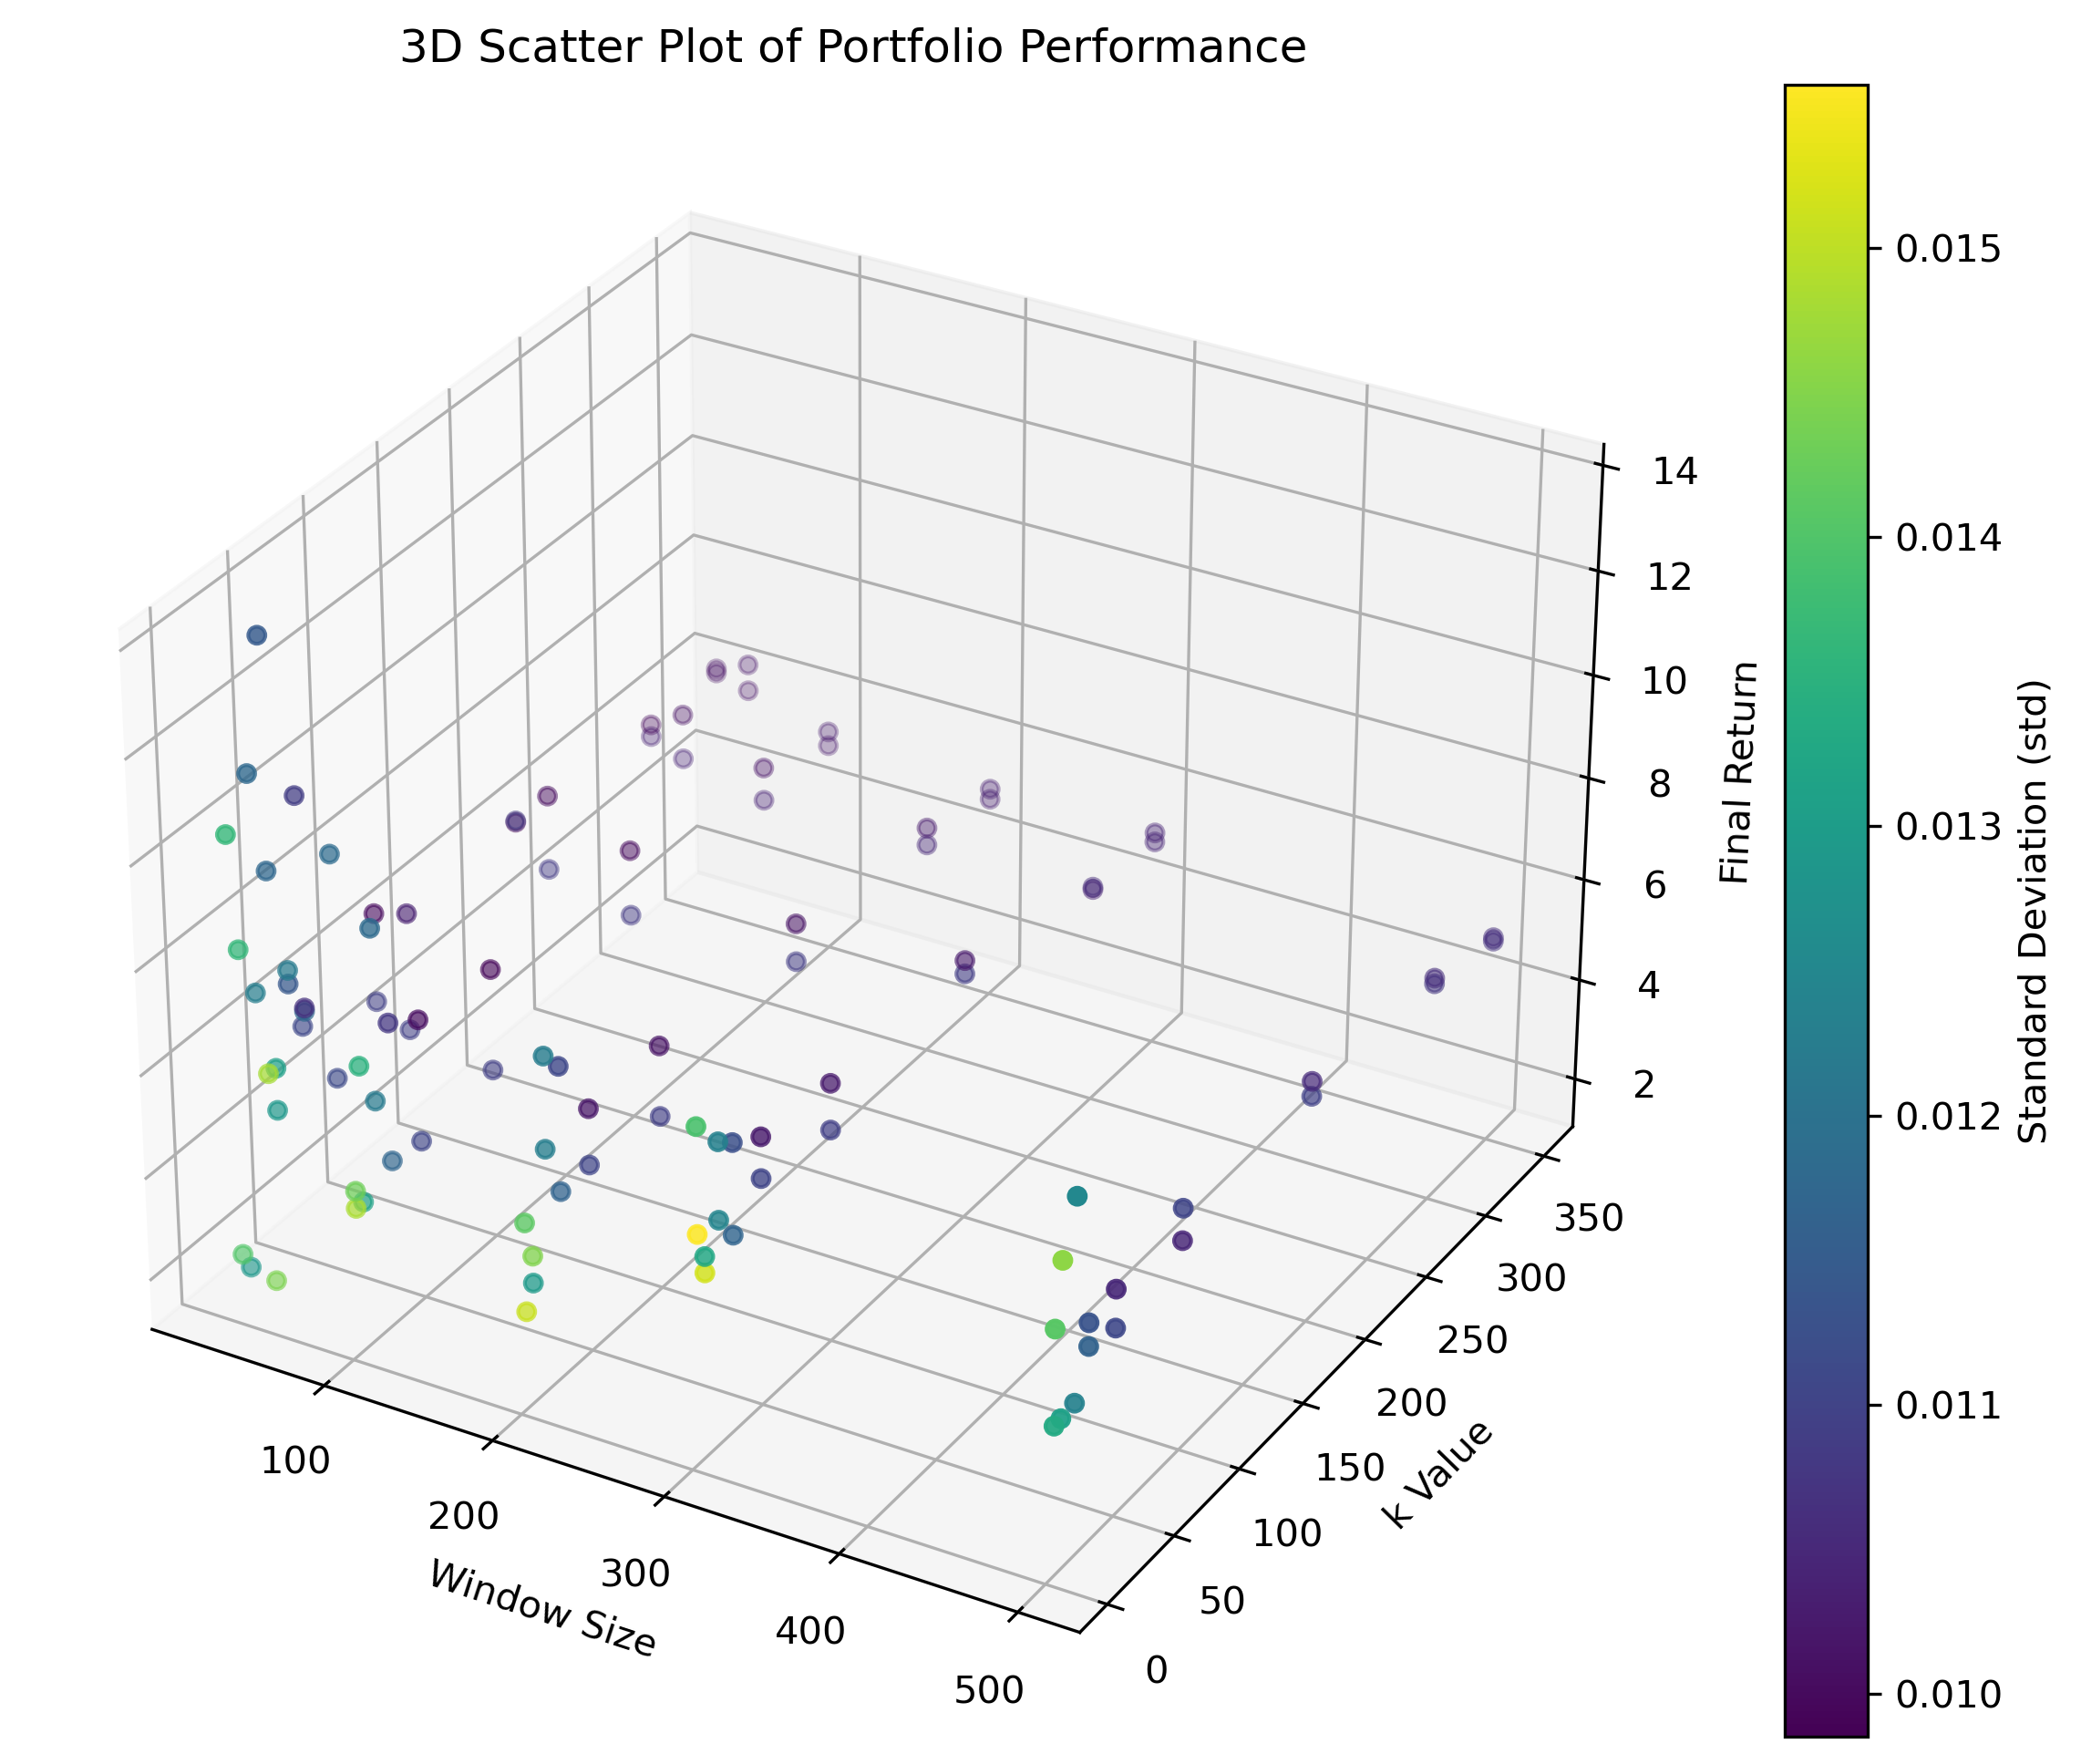

In [46]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建3D散点图
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# 数据点
x = portfolio_performance['window_size']
y = portfolio_performance['k_value']
z = portfolio_performance['final_return']
color = portfolio_performance['std']  # 使用std作为颜色

# 绘制散点图
sc = ax.scatter(x, y, z, c=color, cmap='viridis')

# 添加颜色条
plt.colorbar(sc, ax=ax, label='Standard Deviation (std)')

# 设置坐标轴标签
ax.set_xlabel('Window Size')
ax.set_ylabel('k Value')
ax.set_zlabel('Final Return')

# 设置标题
ax.set_title('3D Scatter Plot of Portfolio Performance')

# 显示图表
plt.show()

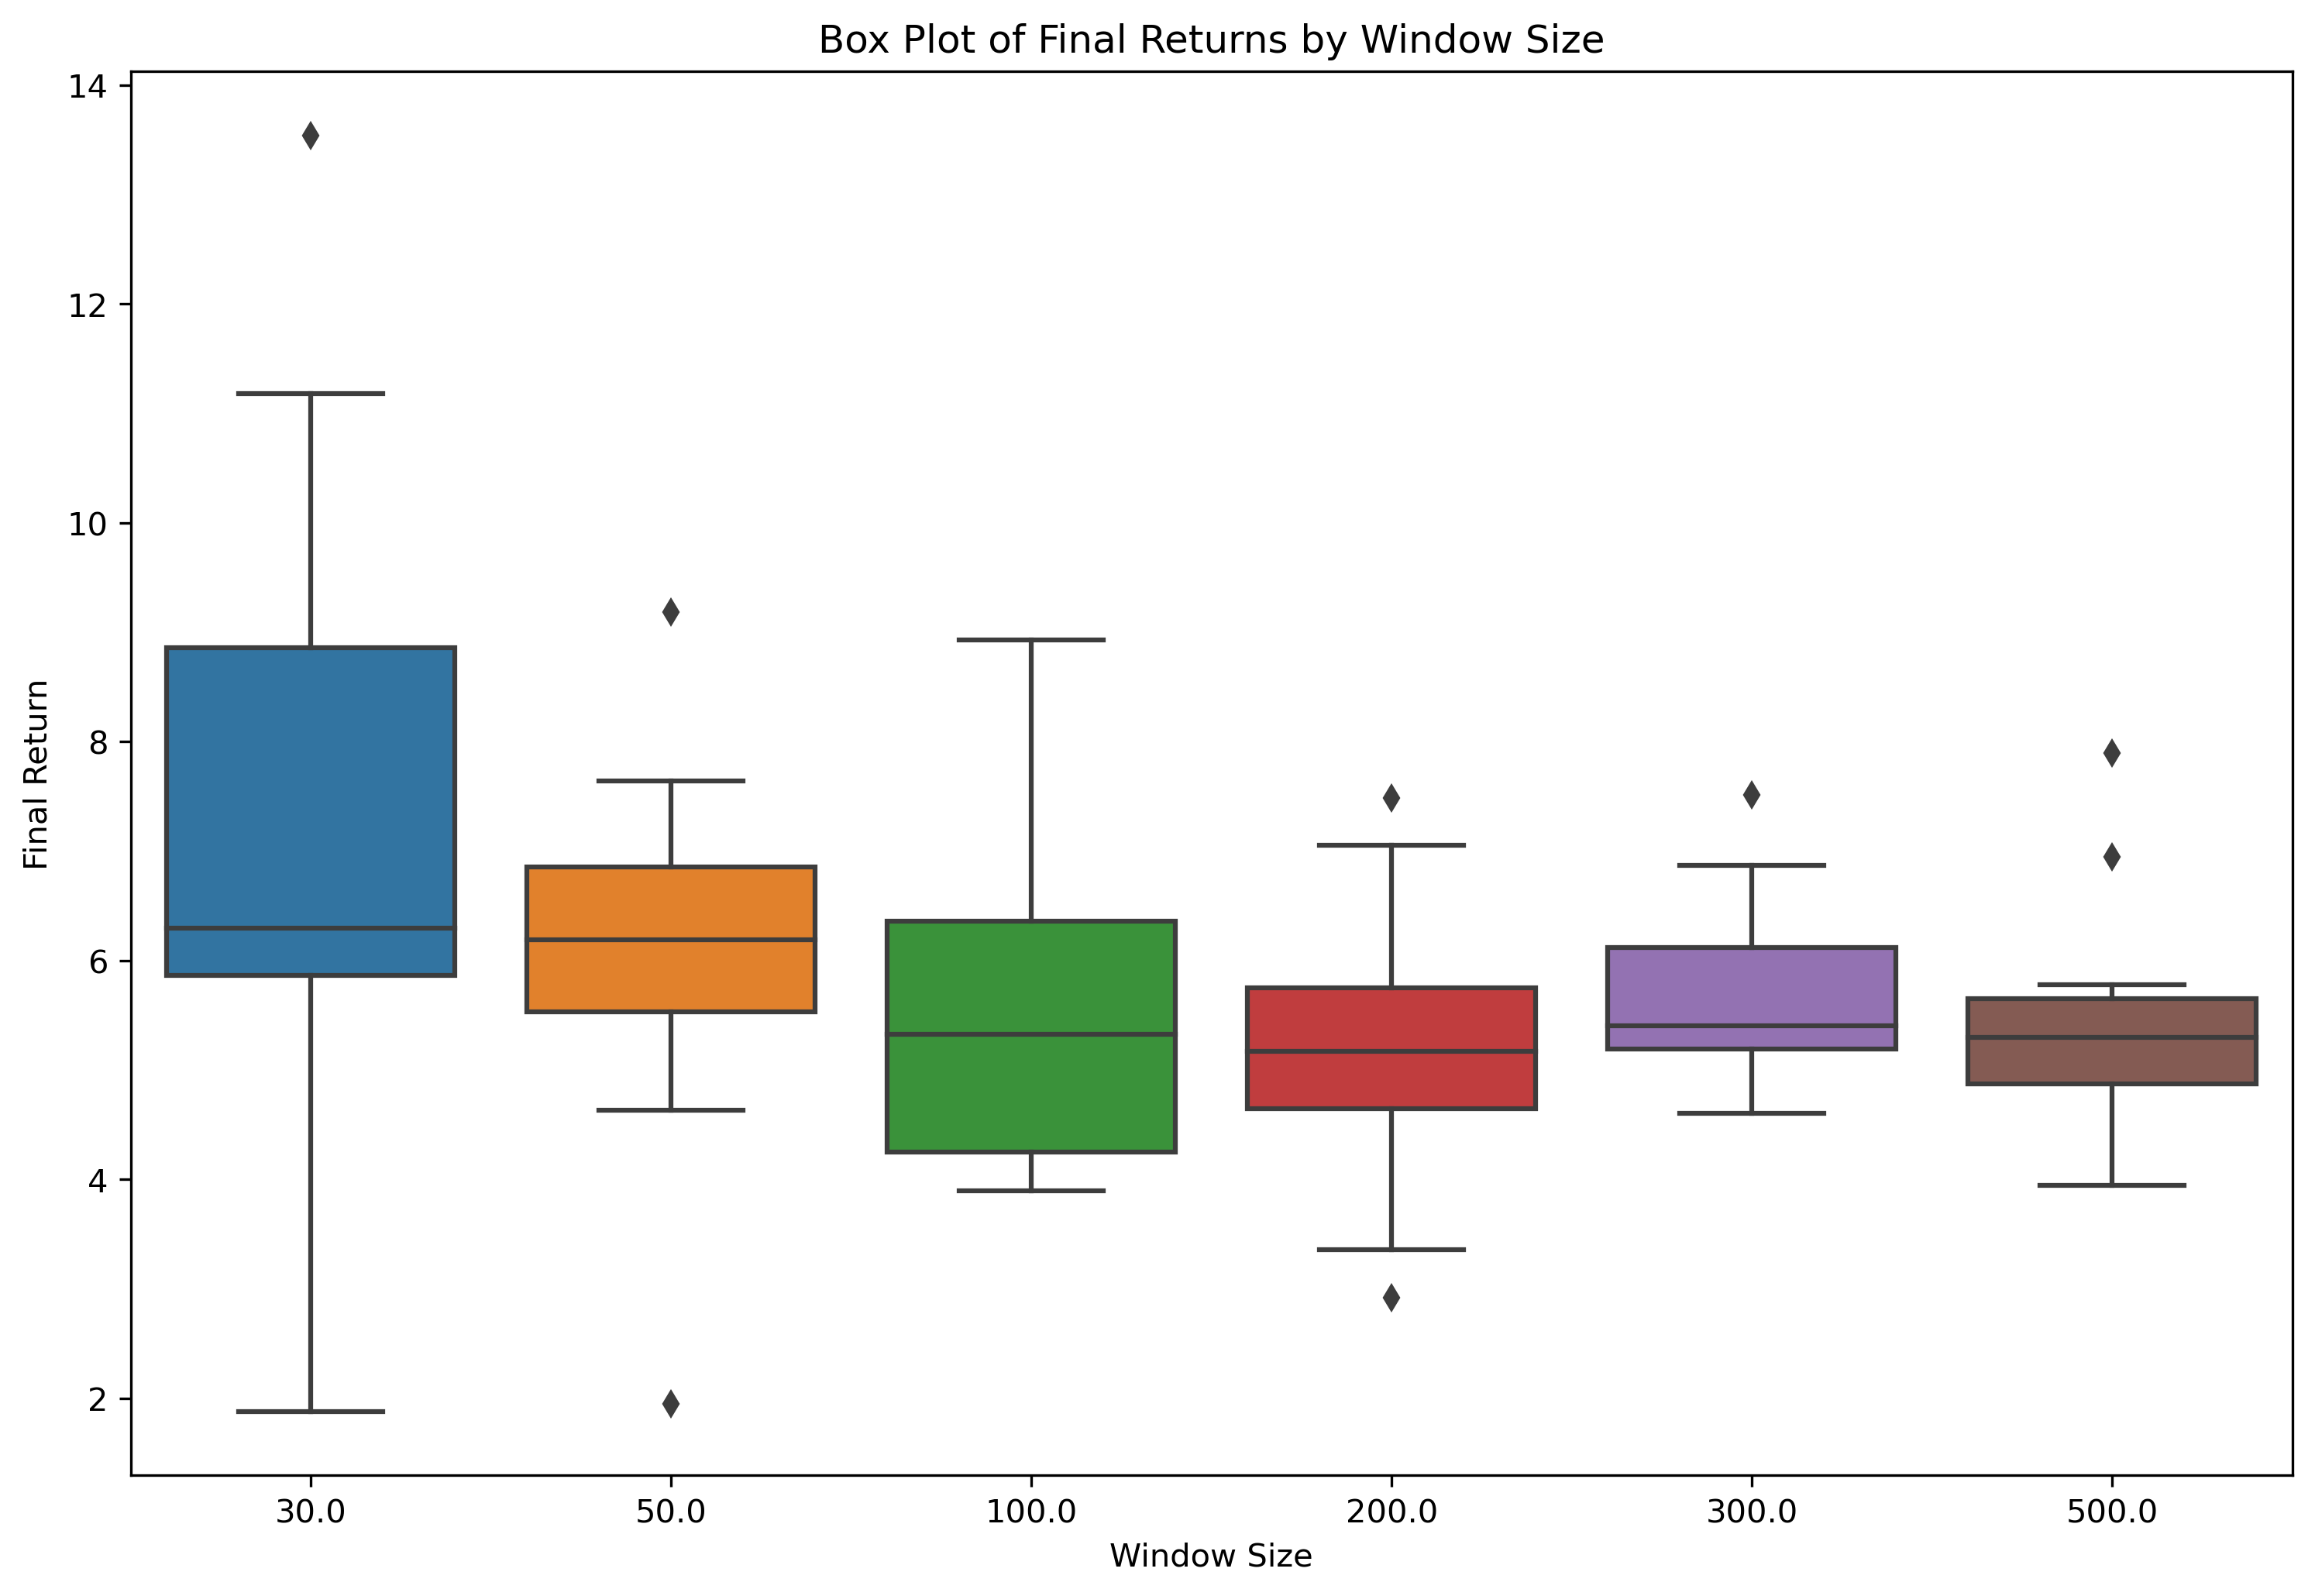

In [47]:
%matplotlib inline
import seaborn as sns

# 设置图形大小
plt.figure(figsize=(12, 8), dpi=300)

# 选择一个变量作为箱型图的分类依据
variable = 'window_size'  # 可以根据需要改为 'k_value'

# 绘制箱型图
sns.boxplot(x=variable, y='final_return', data=portfolio_performance)

# 设置标题和坐标轴标签
plt.title('Box Plot of Final Returns by Window Size')
plt.xlabel('Window Size')
plt.ylabel('Final Return')

# 显示图形
plt.show()

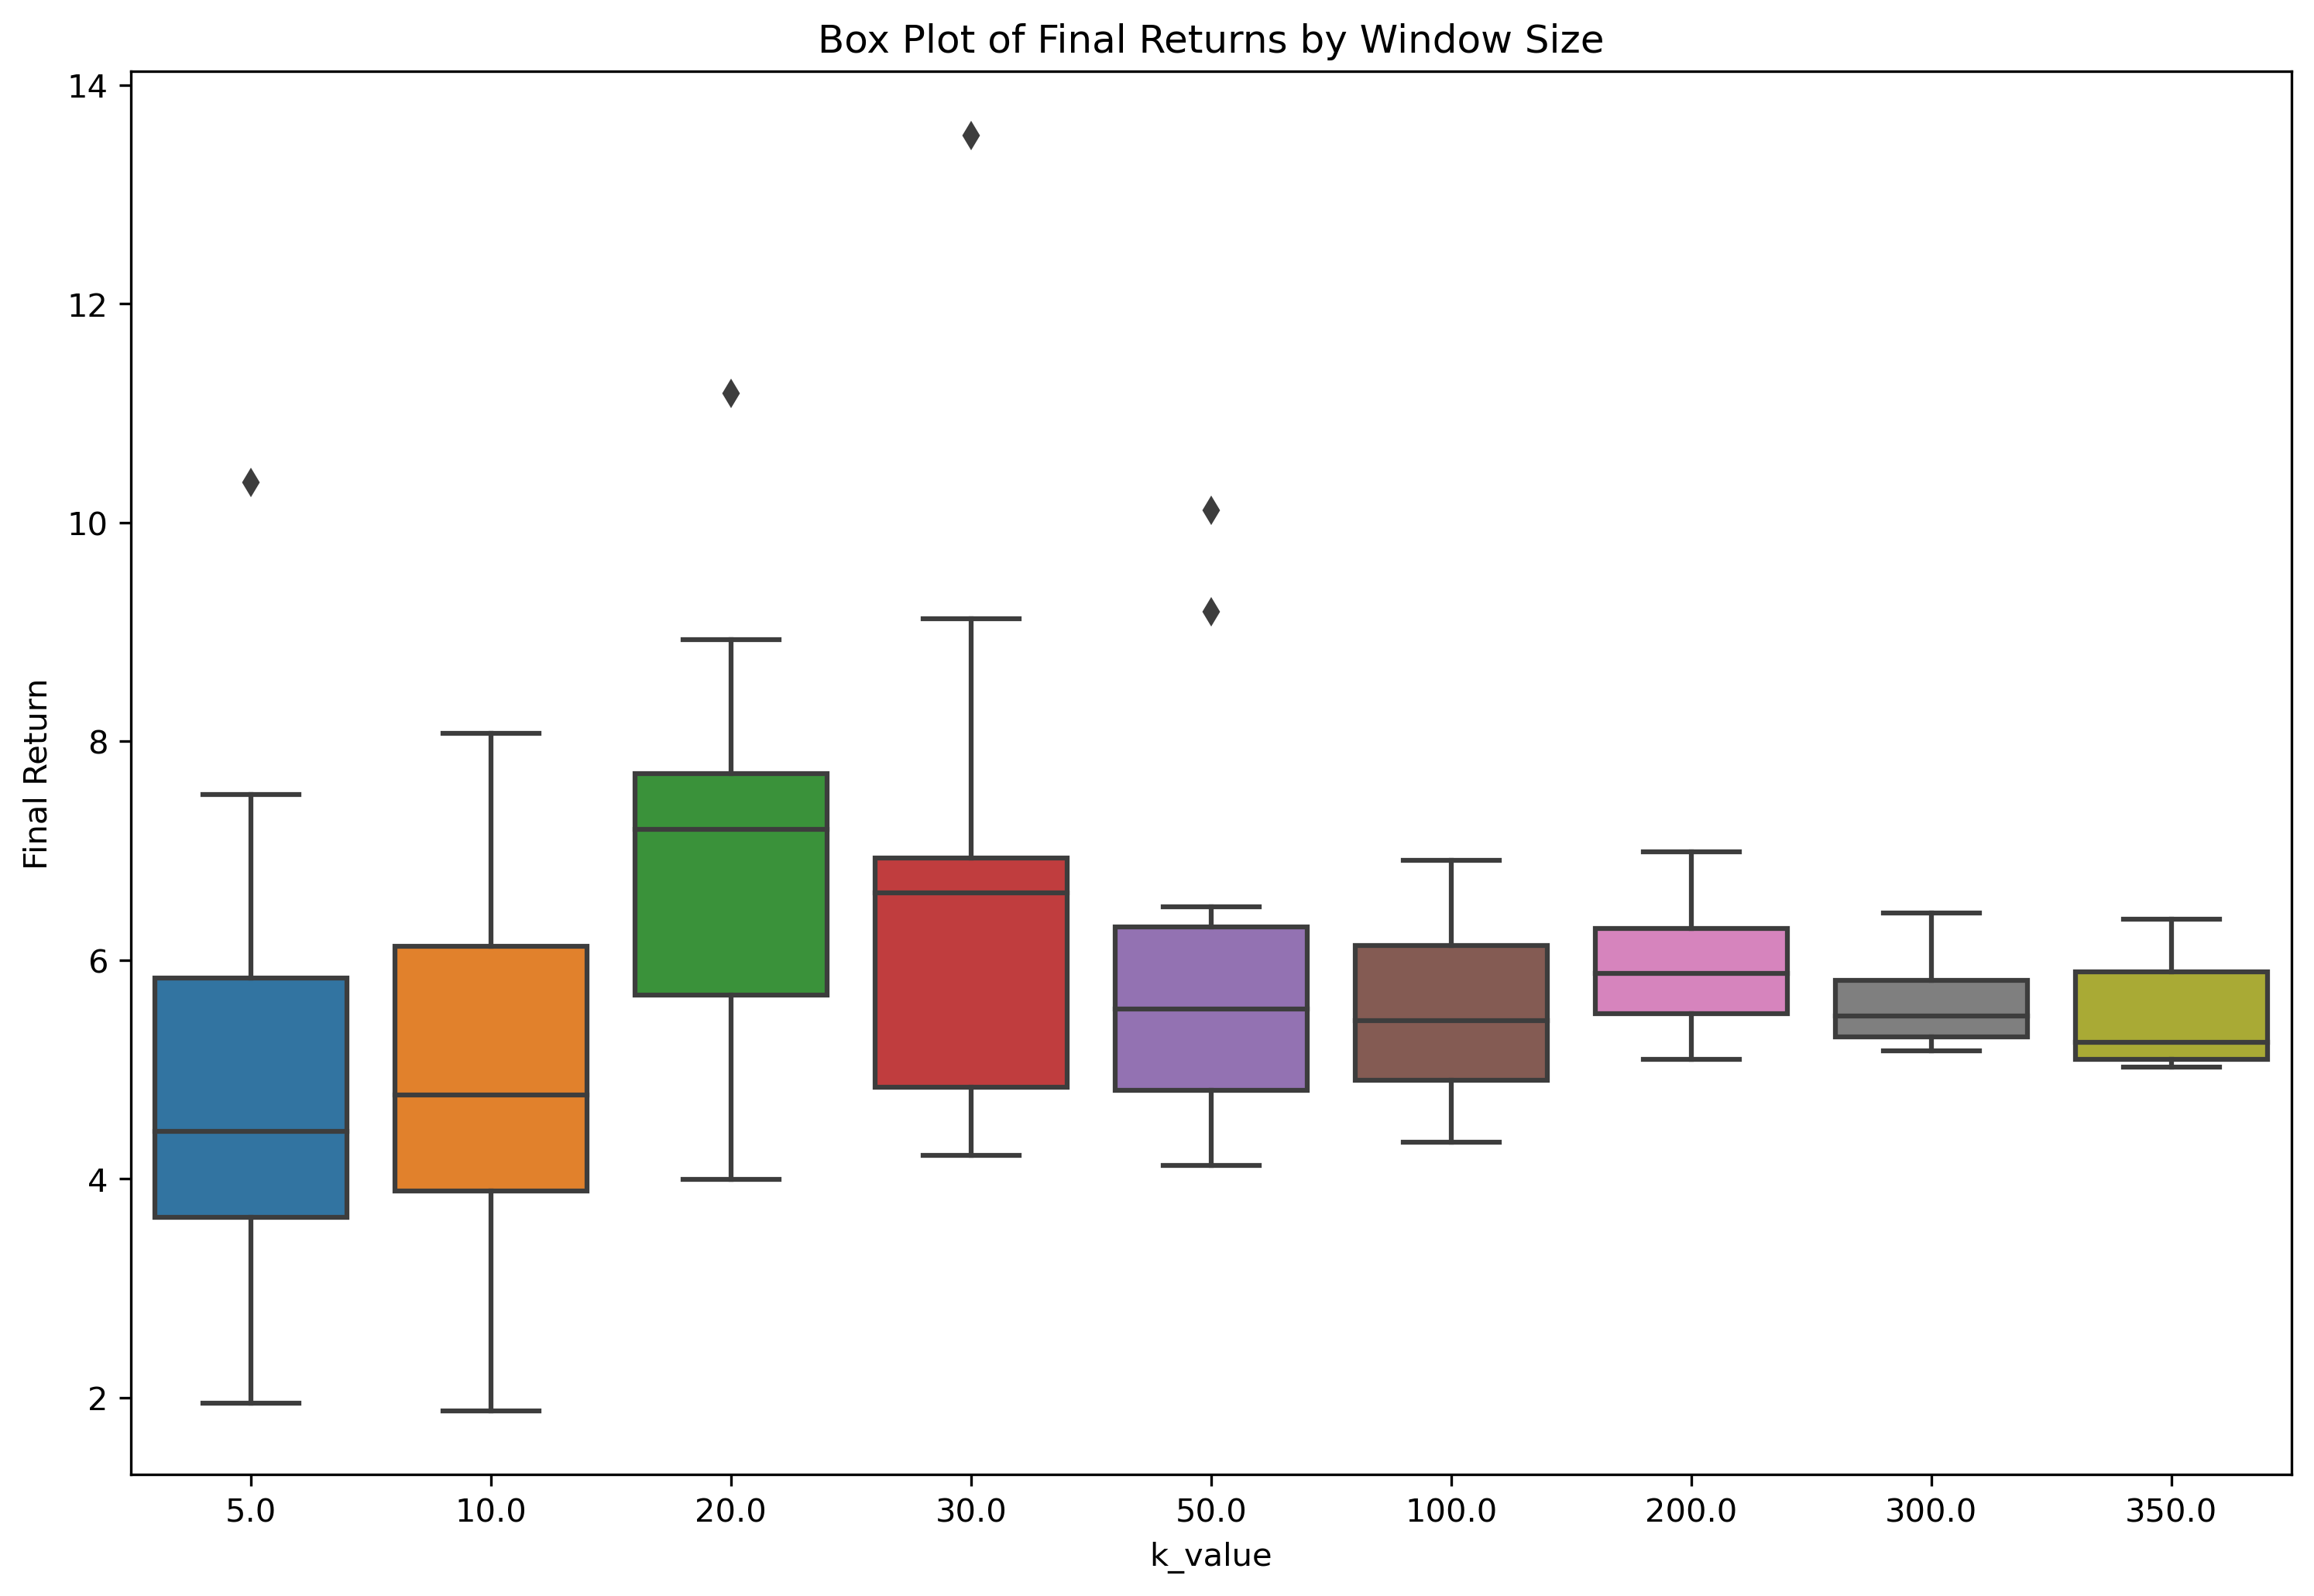

In [50]:
%matplotlib inline
import seaborn as sns

# 设置图形大小
plt.figure(figsize=(12, 8), dpi=300)

# 选择一个变量作为箱型图的分类依据
variable = 'k_value'

# 绘制箱型图
sns.boxplot(x=variable, y='final_return', data=portfolio_performance)

# 设置标题和坐标轴标签
plt.title('Box Plot of Final Returns by Window Size')
plt.xlabel('k_value')
plt.ylabel('Final Return')

# 显示图形
plt.show()

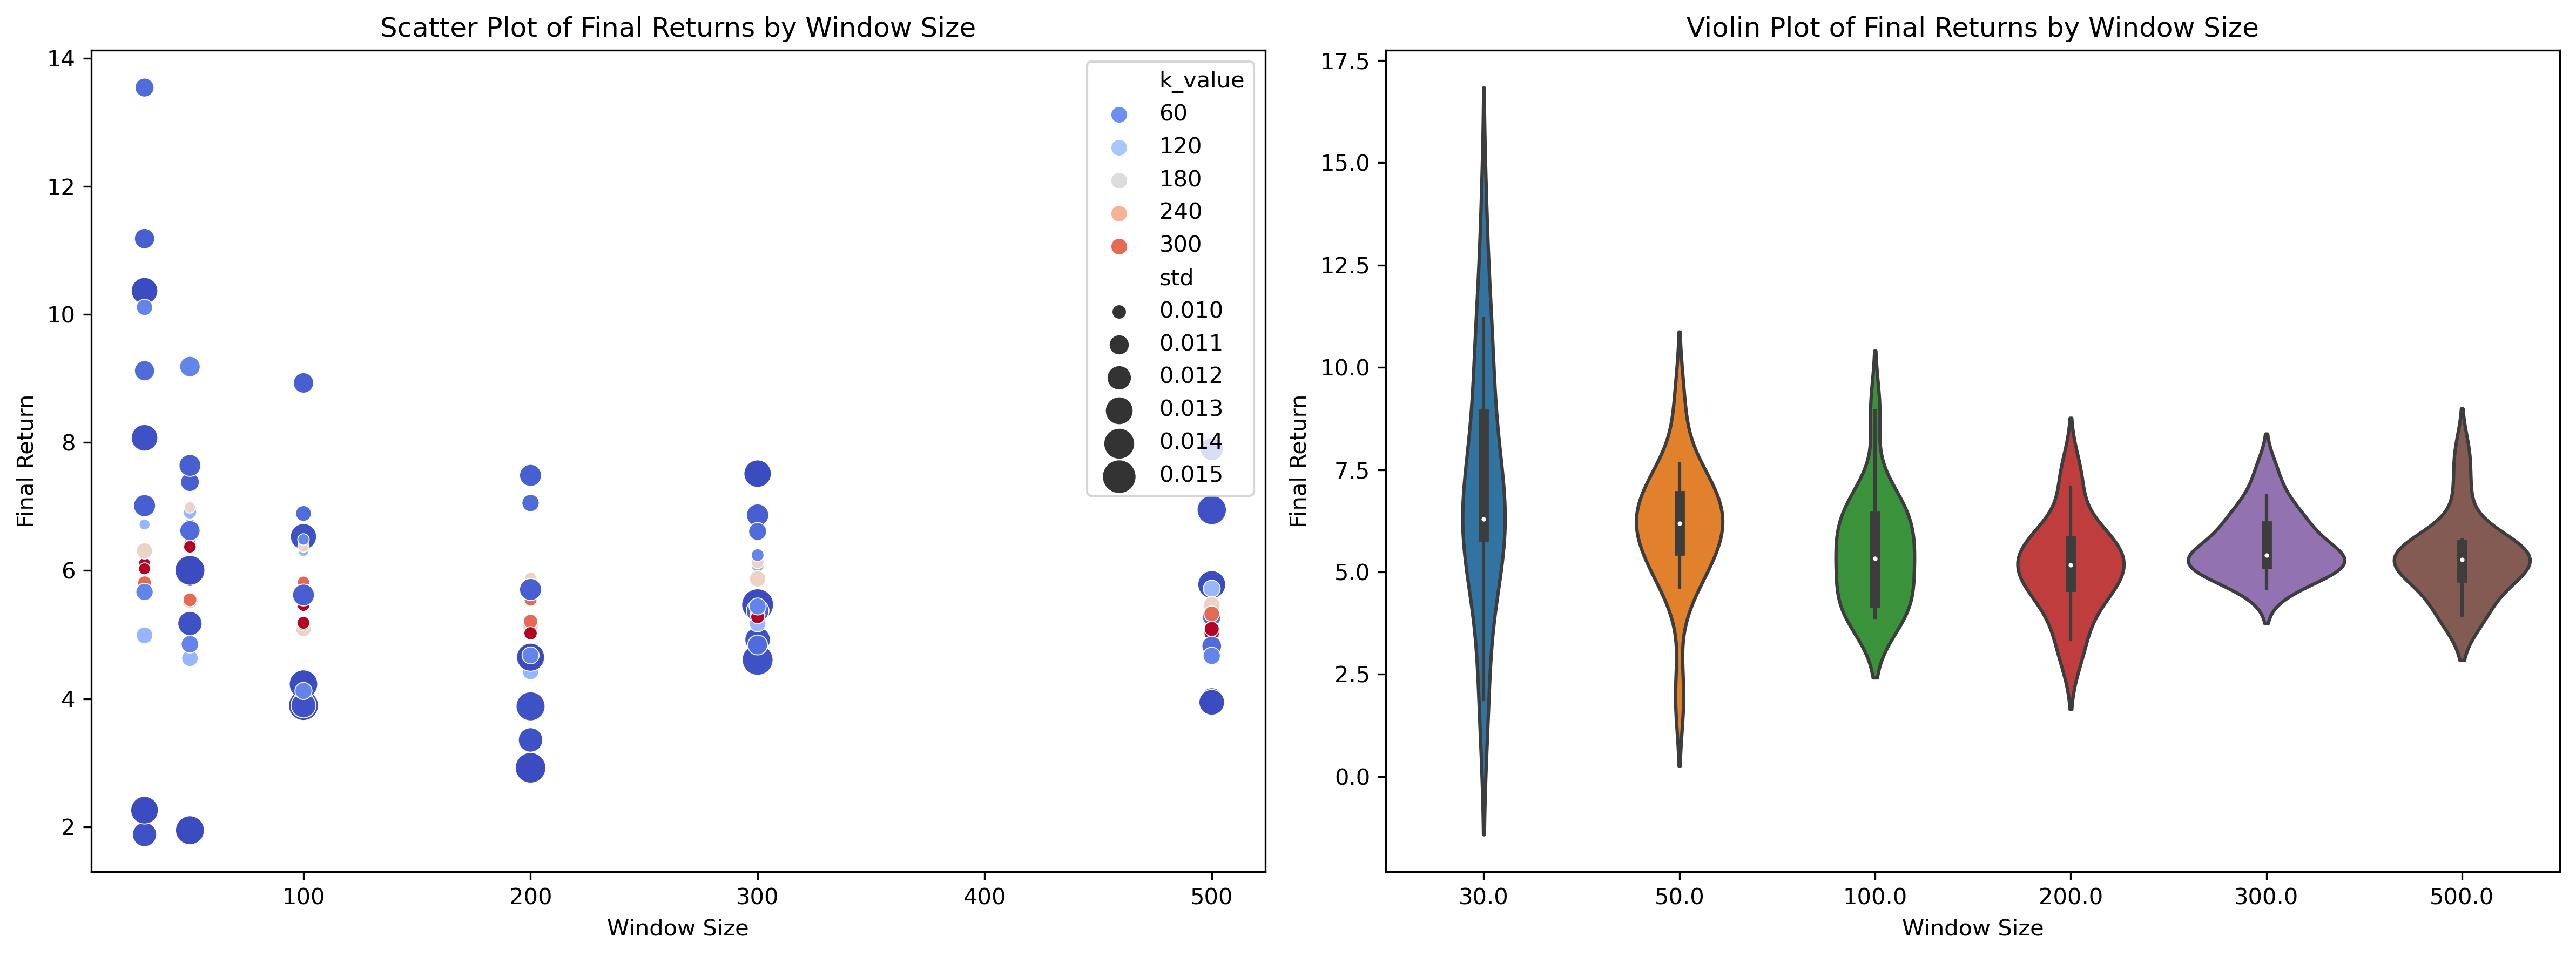

In [51]:
%matplotlib inline

plt.figure(figsize=(16, 6),dpi=300)
plt.subplot(1, 2, 1)

# 绘制散点图
sns.scatterplot(x='window_size', y='final_return', hue='k_value', size='std', sizes=(20, 200), data=portfolio_performance, palette='coolwarm')
plt.title('Scatter Plot of Final Returns by Window Size')
plt.xlabel('Window Size')
plt.ylabel('Final Return')
plt.legend()

# 创建小提琴图
plt.subplot(1, 2, 2)
sns.violinplot(x='window_size', y='final_return', data=portfolio_performance)
plt.title('Violin Plot of Final Returns by Window Size')
plt.xlabel('Window Size')
plt.ylabel('Final Return')


plt.tight_layout()
plt.show()